# Getting Started with a Reflection Spectrum of Jupiter

Hajime Kawahara 3/16 (2025)

In this tutorial, we analyze the high-resolution near-infrared reflection spectrum of Jupiter. 
This is a simplified version of the analysis performed in [exojaxample_jupiter](https://github.com/HajimeKawahara/exojaxample_jupiter).

In this *Getting Started* guide, we include a cloud model for reflected light calculations, making it more detailed than other *Getting Started* guides. It may be helpful to first read about [the Ackerman & Marley cloud model](Ackerman_and_Marley_cloud_model.html).

The spectrum to be analyzed is as follows. The absorption lines observed in the spectrum are primarily due to methane. While a comprehensive line database for methane in the visible range is still lacking (see [here](https://secondearths.sakura.ne.jp/exojax/tutorials/jupiters/Jupiter_Hires_Modeling.html)), the near-infrared range allows for a reasonable explanation of the observed data. Additionally, since this is a reflection spectrum, the original solar spectrum must also be taken into account.

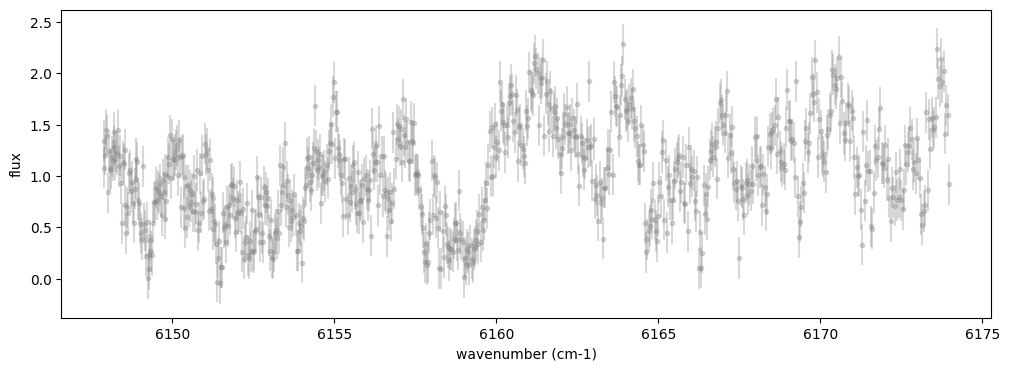

In [1]:
from exojax.test.emulate_spec import sample_reflection_spectrum
import matplotlib.pyplot as plt

nu_obs, flux, err_flux = sample_reflection_spectrum()

fig = plt.figure(figsize=(12,4))
plt.errorbar(nu_obs,flux,yerr=err_flux,fmt=".",color="gray", alpha=0.3)
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("flux")
plt.show()

I found very good one: High-resolution solar spectrum taken from Meftar et al. (2023). Get the data.

- 10.21413/SOLAR-HRS-DATASET.V1.1_LATMOS
- http://doi.latmos.ipsl.fr/DOI_SOLAR_HRS.v1.1.html
- http://bdap.ipsl.fr/voscat_en/solarspectra.html


In [2]:
from exojax.spec.unitconvert import wav2nu
import pandas as pd
filename = "/home/kawahara/solar-hrs/Spectre_HR_LATMOS_Meftah_V1.txt"
dat = pd.read_csv(filename, names=("wav","flux"), comment=";", delimiter="\t")
dat["wav"] = dat["wav"]*10

wav_solar = dat["wav"][::-1]
solspec = dat["flux"][::-1]
nus_solar = wav2nu(wav_solar,unit="AA")

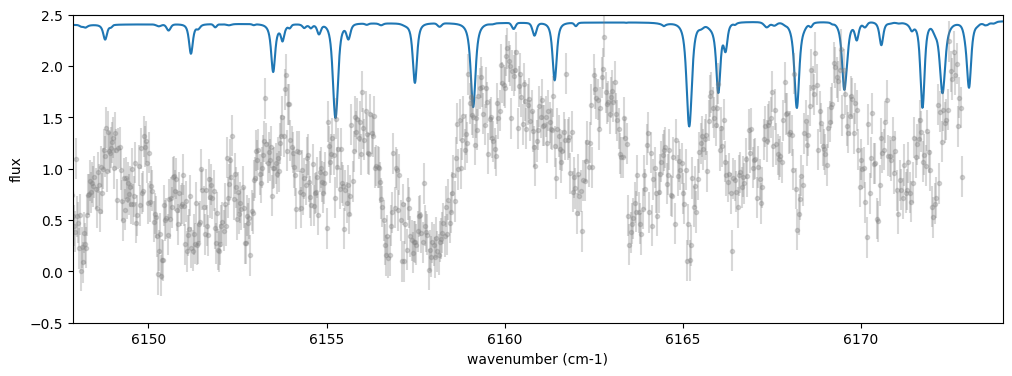

In [3]:
from exojax.utils.constants import c
vrv = -55 #km/s
fig = plt.figure(figsize=(12,4))
plt.plot(nus_solar,solspec*10)
plt.errorbar(nu_obs*(1 + vrv/c),flux,yerr=err_flux,fmt=".",color="gray", alpha=0.3)
plt.xlim(nu_obs[0],nu_obs[-1])
plt.ylim(-0.5,2.5)
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("flux")
plt.show()

Now, we will use `ArtReflectPure` for the radiative transfer of reflected light. 

In [4]:
import numpy as np
from exojax.utils.grids import wavenumber_grid
from exojax.spec.atmrt import ArtReflectPure

nus, wav, res = wavenumber_grid(
    np.min(nu_obs) - 5.0, np.max(nu_obs) + 5.0, 10000, xsmode="premodit", unit="cm-1"
)

art = ArtReflectPure(
        nu_grid=nus, pressure_btm=3.0e1, pressure_top=1.0e-3, nlayer=200
    )

xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: xsmode=premodit
Your wavelength grid is in ***  descending  *** order
The wavenumber grid is in ascending order by definition.
Please be careful when you use the wavelength grid.


/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:13: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


Now, let's use the temperature-pressure (T-P) profile of Jupiter obtained by the Galileo probe. Please install [jovispec](https://github.com/HajimeKawahara/jovispec).

In [5]:
from jovispec.tpio import read_tpprofile_jupiter
dat = read_tpprofile_jupiter()
torig = dat["Temperature (K)"]
porig = dat["Pressure (bar)"]

Let's interpolate the temperature grid to match the pressure grid of `art`. For simplicity, we will assume an isothermal atmosphere in the upper layers.

In [6]:
Tarr_np = np.interp(art.pressure, porig, torig)
i = np.argmin(Tarr_np)
Tarr_np[0:i] = Tarr_np[i]

# acutually, this just convert Tarr_np to jnp.array
Tarr = art.custom_temperature(Tarr_np)

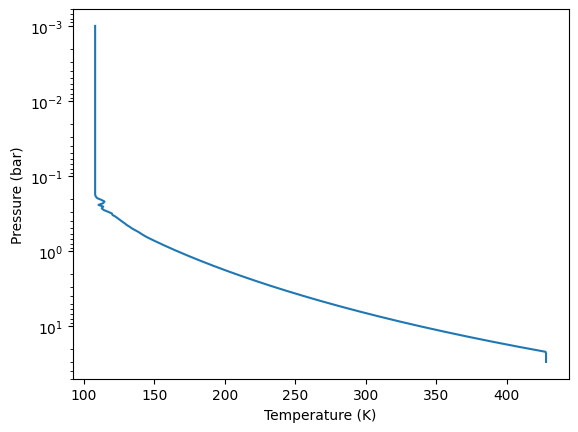

In [7]:
plt.plot(Tarr,art.pressure)
plt.yscale("log")
plt.gca().invert_yaxis()
plt.xlabel("Temperature (K)")
plt.ylabel("Pressure (bar)")
plt.show()

Set the mean molecular weight and gravity.

In [8]:
from exojax.utils.astrofunc import gravity_jupiter
mu = 2.22  # mean molecular weight NASA Jupiter fact sheet
gravity = gravity_jupiter(1.0, 1.0)

In Jupiter's atmosphere, the primary reflectors of sunlight are ammonia clouds. Therefore, we retrieve ammonia from the `PdbCloud` database. As the cloud model, we use the [Ackerman & Marley (AM)-like model](Ackerman_and_Marley_cloud_model.html), which can be accessed via `AmpAmcloud` from `atmphys`. 

Whether a simple gray cloud model would suffice is worth considering. Using an overly complex model for the data can obscure the assumptions being made. However, since the cloud composition and the T-P profile of Jupiter are well understood, using an AM model should not be excessive.

In [9]:
from exojax.spec.pardb import PdbCloud
from exojax.atm.atmphys import AmpAmcloud


pdb_nh3 = PdbCloud("NH3")
amp_nh3 = AmpAmcloud(pdb_nh3, bkgatm="H2")
amp_nh3.check_temperature_range(Tarr)

.database/particulates/virga/virga.zip  exists. Remove it if you wanna re-download and unzip.
Refractive index file found:  .database/particulates/virga/NH3.refrind
Miegrid file exists: .database/particulates/virga/miegrid_lognorm_NH3.mg.npz


/home/kawahara/exojax/src/exojax/atm/atmphys.py:54: UserWarning: min temperature 107.99141693115234 K is smaller than min(vfactor t range) 179.10000610351562 K
  warnings.warn(


We calculate the condensate substance density of cloud particles. Based on Jupiter's observations, we assume an ammonia abundance three times the solar composition. Finally, we define the mass mixing ratio of ammonia at the cloud base.

In [10]:
from exojax.utils.zsol import nsol
from exojax.atm.atmconvert import vmr_to_mmr
from exojax.spec.molinfo import molmass_isotope

# condensate substance density
rhoc = pdb_nh3.condensate_substance_density  # g/cc
n = nsol("AG89")
abundance_nh3 = 3.0 * n["N"]  # x 3 solar abundance
molmass_nh3 = molmass_isotope("NH3", db_HIT=False)
MMRbase_nh3 = vmr_to_mmr(abundance_nh3, molmass_nh3, mu)

Database for solar abundance =  AG89
Anders E. & Grevesse N. (1989, Geochimica et Cosmochimica Acta 53, 197) (Photospheric, using Table 2)


In the AM model, parameters are currently made differentiable by creating a grid dataset called `miegrid` and interpolating it. The parameters of `miegrid` are `sigmag` and `rg` in the AM model; however, in this example, we fix `sigmag` and create a grid only for `rg`. How should we determine the grid range for `rg`? Let's convert the expected range of `fsed` (here 0.1 - 10) to `rg` and use that to define the grid range.

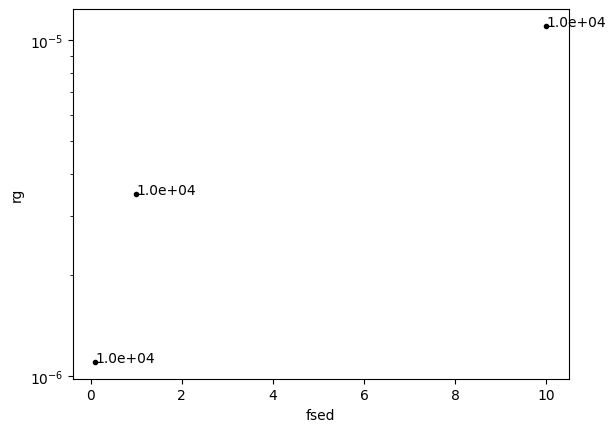

In [11]:
fsed_range = [0.1, 10.0]
Kzz_fixed = 1.0e4
sigmag_fixed = 2.0
vrv_fixed = 0.0
N_fsed = 3

fsed_grid = np.logspace(np.log10(fsed_range[0]), np.log10(fsed_range[1]), N_fsed)

rg_val = []
for fsed in fsed_grid:
    rg_layer, MMRc = amp_nh3.calc_ammodel(
        art.pressure, Tarr, mu, molmass_nh3, gravity, fsed, sigmag_fixed, Kzz_fixed, MMRbase_nh3
    )
    rg_val.append(np.nanmean(rg_layer))
    plt.plot(fsed, np.nanmean(rg_layer), ".", color="black")
    plt.text(fsed, np.nanmean(rg_layer), f"{Kzz_fixed:.1e}")
rg_val = np.array(rg_val)
plt.yscale("log")
plt.xlabel("fsed")
plt.ylabel("rg")
plt.show()


Through the above procedure, we found that `rg` should be gridded over approximately one order of magnitude, ranging from \(10^{-5}\) to \(10^{-6}\). The `miegrid` can be generated using `generate_miegrid` from `pdb`. Once generated, it does not need to be regenerated for future use.

This `miegrid` uses [PyMieScatt](https://github.com/bsumlin/PyMieScatt) as the backend. If you installed it via pip, you might encounter an error with `scipy.integrate.trapz`. In that case, clone the repository from GitHub and install it using `python setup.py install`.

https://github.com/bsumlin/PyMieScatt

In [12]:
rg_range = [np.min(rg_val), np.max(rg_val)]
N_rg = 10
print("rg range=",rg_range)
    
pdb_nh3.generate_miegrid(
        sigmagmin=sigmag_fixed,
        sigmagmax=sigmag_fixed,
        Nsigmag=1,
        log_rg_min=np.log10(rg_range[0]),
        log_rg_max=np.log10(rg_range[1]),
        Nrg=N_rg,
)

rg range= [1.1033209e-06, 1.1033208e-05]
sigmag arr =  [2.]


100%|██████████| 1/1 [09:09<00:00, 549.61s/it]

miegrid_lognorm_NH3.mg  was generated.


If you have already generated *miegrid*, you can load it using `load_miegrid`.

In [13]:
pdb_nh3.load_miegrid()

pdb.miegrid, pdb.rg_arr, pdb.sigmag_arr are now available. The Mie scattering computation is ready.


We assume that cloud scattering follows Mie scattering. The `opa` for Mie scattering is `OpaMie`.

In [14]:
from exojax.spec.opacont import OpaMie

opa_nh3 = OpaMie(pdb_nh3, nus)

In [15]:
from exojax.spec.api import MdbHitemp
mdb_reduced = MdbHitemp("CH4", nurange=[nus[0], nus[-1]], isotope=1, elower_max=3300.0)

radis engine =  pytables
Login successful.
Starting download from https://hitran.org/files/HITEMP/bzip2format/06_HITEMP2020.par.bz2 to 06_HITEMP2020.par.bz2
Total size to download: 445562914 bytes


06_HITEMP2020.par.bz2: 100%|██████████| 446M/446M [01:22<00:00, 5.39MB/s] 



Download complete!


In [30]:
import jax.numpy as jnp
from exojax.spec.opacalc import OpaPremodit

opa = OpaPremodit(mdb_reduced, nu_grid=nus, allow_32bit=True, auto_trange=[80.0, 300.0])  

## Spectrum Model
nusjax = jnp.array(nus)
nusjax_solar = jnp.array(nus_solar)
solspecjax = jnp.array(solspec)


/home/kawahara/exojax/src/exojax/utils/jaxstatus.py:19: UserWarning: JAX uses 32bit mode. 
You can change to 64bit mode by writing 

    from jax import config 
    config.update("jax_enable_x64", True)

  warnings.warn(msg+how_change_msg)


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 79.45501192821337 - 740.1245313998245 K
OpaPremodit: Tref_broadening is set to  154.91933384829665 K
OpaPremodit: gamma_air and n_air are used. gamma_ref = gamma_air/Patm
# of reference width grid :  7
# of temperature exponent grid : 4
max value of  ngamma_ref_grid : 31.65553199866716
min value of  ngamma_ref_grid : 13.8937057424919
ngamma_ref_grid grid : [13.89370441 15.93761568 18.28220622 20.97171063 24.05686937 27.59588734
 31.65553474]
max value of  n_Texp_grid : 1.13
min value of  n_Texp_grid : 0.57
n_Texp_grid grid : [0.56999993 0.75666667 0.94333333 1.13000011]


uniqidx: 100%|██████████| 8/8 [00:00<00:00, 1674.71it/s]

Premodit: Twt= 328.42341041740974 K Tref= 91.89455622053987 K
Making LSD:|####################| 100%


cross section (xsvector/xsmatrix) is calculated in the closed mode. The aliasing part cannnot be used.
wing cut width =  [35.893247577590955, 36.31638492791535] cm-1


Encapsulate the methane opacity calculation into a function.

In [28]:
molmass_ch4 = molmass_isotope("CH4", db_HIT=False)

def methane_opacity(const_mmr_ch4):
    mmr_ch4 = art.constant_mmr_profile(const_mmr_ch4)
    xsmatrix = opa.xsmatrix(Tarr, art.pressure)
    dtau_ch4 = art.opacity_profile_xs(xsmatrix, mmr_ch4, molmass_ch4, gravity)
    return dtau_ch4

Oh, I almost forgot—this data was obtained from a test observation of Jupiter using a 20 cm telescope before installing the IRD spectrograph on the Subaru Telescope. For details, ask Takayuki Kotani. A spectral resolution of around 25,000 seems appropriate.

In [17]:
from exojax.spec.specop import SopInstProfile

# asymmetric_parameter = asymmetric_factor + np.zeros((len(art.pressure), len(nus)))
reflectivity_surface = np.zeros(len(nus))
sop = SopInstProfile(nus)

broadening = 25000.0

Since we want to normalize the data for optimization, we encapsulate the related operations into a function. This is not necessary if using only HMC.

In [ ]:
def unpack_params(params):
        multiple_factor = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0, 10000.0, 0.01, 1.0])
        par = params * multiple_factor
        log_fsed = par[0]
        sigmag = par[1]
        log_Kzz = par[2]
        vrv = par[3]
        vv = par[4]
        _broadening = par[5]
        const_mmr_ch4 = par[6]
        factor = par[7]
        fsed = 10**log_fsed
        Kzz = 10**log_Kzz

        return fsed, sigmag, Kzz, vrv, vv, _broadening, const_mmr_ch4, factor



Next, we define the long-awaited atmospheric model. The key point here is that `rg` does not vary significantly across atmospheric layers, so we use the average as the representative value.

We calculate *the Three Sacred Treasures* in [the two-stream approximation for radiative transfer of reflected and scattered light](../userguide/rtransfer_fbased.html): opacity, single scattering albedo, and the asymmetry parameter.



In [21]:

def atmospheric_model(params):
        # unused parameters are marked with _
        fsed, _sigmag, _Kzz, _vrv, vv, _broadening, const_mmr_ch4, factor = (
            unpack_params(params)
        )

        broadening = 25000.0
        rg_layer, MMRc = amp_nh3.calc_ammodel(
            art.pressure,
            Tarr,
            mu,
            molmass_nh3,
            gravity,
            fsed,
            sigmag_fixed,
            Kzz_fixed,
            MMRbase_nh3,
        )
        rg = jnp.mean(rg_layer)

        sigma_extinction, sigma_scattering, asymmetric_factor = (
            opa_nh3.mieparams_vector(rg, sigmag_fixed)
        )
        dtau_cld = art.opacity_profile_cloud_lognormal(
            sigma_extinction, rhoc, MMRc, rg, sigmag_fixed, gravity
        )
        dtau_cld_scat = art.opacity_profile_cloud_lognormal(
            sigma_scattering, rhoc, MMRc, rg, sigmag_fixed, gravity
        )

        asymmetric_parameter = asymmetric_factor + np.zeros(
            (len(art.pressure), len(nus))
        )

        dtau_ch4 = methane_opacity(const_mmr_ch4)
        single_scattering_albedo = (dtau_cld_scat) / (dtau_cld + dtau_ch4)
        dtau = dtau_cld + dtau_ch4
        return (
            vv,
            factor,
            broadening,
            asymmetric_parameter,
            single_scattering_albedo,
            dtau,
        )

Next, we define the spectral model. Since the atmospheric model has been defined separately, this definition remains concise.

In [22]:
from exojax.utils.instfunc import resolution_to_gaussian_std

def spectral_model(params):
    vv, factor, broadening, asymmetric_parameter, single_scattering_albedo, dtau = (
        atmospheric_model(params)
    )
    # velocity
    vpercp = (vrv_fixed + vv) / c
    incoming_flux = jnp.interp(nusjax, nusjax_solar * (1.0 + vpercp), solspecjax)

    Fr = art.run(
        dtau,
        single_scattering_albedo,
        asymmetric_parameter,
        reflectivity_surface,
        incoming_flux,
    )

    std = resolution_to_gaussian_std(broadening)
    Fr_inst = sop.ipgauss(Fr, std)
    Fr_samp = sop.sampling(Fr_inst, vv, nu_obs)
    return factor * Fr_samp

In [33]:
from jax import jacfwd
import jax.numpy as jnp


def cost_function(params):
    return jnp.sum((flux - spectral_model(params)) ** 2)


def dfluxt_jacfwd(params):
    return jacfwd(cost_function)(params)


parinit = jnp.array(
    [jnp.log10(3.0), sigmag_fixed, jnp.log10(Kzz_fixed), -5.0, -55.0, 2.5, 1.0, 0.6]
)

In [36]:

import optax
import tqdm

solver = optax.adamw(learning_rate=1.e-2)

params = np.copy(parinit)
state = solver.init(params)
val = []
loss = []
for _ in tqdm.tqdm(range(5000)):
    grad = dfluxt_jacfwd(params)
    updates, state = solver.update(grad, state, params)
    params = optax.apply_updates(params, updates)
    val.append(params)
    loss.append(cost_function(params))
val = np.array(val)
loss = np.array(loss)



 13%|█▎        | 674/5000 [02:47<17:51,  4.04it/s]


KeyboardInterrupt: 

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(loss)
plt.yscale("log")
plt.show()

# res.params
print("fsed, sigmag, Kzz, vrv, vr, _broadening, const_mmr_ch4, factor")
print("init:", unpack_params(parinit))
print("best:", unpack_params(params))

print("fsed, sigmag, Kzz, vrv, vr, _broadening, const_mmr_ch4, factor")
print("best (packed):", params)

F_samp = spectral_model(params)
F_samp_init = spectral_model(parinit)